In [1]:
# %%
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import polars as pl
import pandas as pd
import numpy as np
import json
import os
import sys

sys.path.append("..")

import seaborn as sns

sns.set()
from settings import (
    random_state,
    PROJECT_PATH,
    REGRESSION_TARGET,
    CLASSIFICATION_TARGET,
)
from catboost import CatBoostRegressor



In [2]:
transactions = pl.read_parquet(
    os.path.join(PROJECT_PATH, "transactions_post_feature_engineering.parquet")
)

In [3]:
X = transactions.drop([REGRESSION_TARGET, CLASSIFICATION_TARGET]).to_pandas()
y_regression = transactions[REGRESSION_TARGET].to_pandas()

In [4]:
with open("../features_used.json", "r") as f:
    feature_names = json.load(f)

with open("../categorical_features_used.json", "r") as f:
    categorical_features = json.load(f)

numerical_features = [col for col in feature_names if col not in categorical_features]

In [5]:
catboost_regressor = CatBoostRegressor(random_state=random_state, verbose=False)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_regression, random_state=random_state
)

In [8]:
catboost_regressor.fit(X_train[feature_names], y_train)

In [9]:
y_pred_train = catboost_regressor.predict(X_train)
errors = y_train - y_pred_train    
X_train["error"] = errors

y_pred_test = catboost_regressor.predict(X_test)
errors = y_test - y_pred_test    
X_test["error"] = errors

Le graphique le plus classique pour visualiser le lien entre une feature catégorielle et une feature quantitative est le boxplot. Cependant, notre librairie de visualisation seaborn ne peut pas prendre les données telles quelles, avec le One Hot Encoding qui nous avons réalisé !

Nous devons d'abord inverser cette étape pour avoir une colonne catégorielle "brute" que nous pouvons passer à seaborn pour le tracé du graphique.

In [10]:
# En regardant nos features, il faut inverser l'encoding pour la region et le type de batiment 
categorical_features

['type_batiment_Appartement',
 'type_batiment_Maison',
 'vefa',
 'ville_demandee',
 'nom_region_Auvergne-Rhône-Alpes',
 'nom_region_Nouvelle-Aquitaine',
 'nom_region_Occitanie',
 "nom_region_Provence-Alpes-Côte d'Azur",
 'nom_region_Île-de-France']

In [11]:
def reverse_one_hot_encoding(X, feature_name, ):

    X[feature_name] = pd.from_dummies(
        X[[col for col in X.columns if col.startswith(feature_name)]]
    )

    X = X.drop(
        [col for col in X.columns if col.startswith(feature_name + "_")], axis=1
    )

    return X

In [12]:
# Nous créons des dataframe "group" pour ne pas toucher aux features d'origine
X_train_group = reverse_one_hot_encoding(X_train, "nom_region")
X_test_group = reverse_one_hot_encoding(X_test, "nom_region")

X_train_group = reverse_one_hot_encoding(X_train_group, "type_batiment")
X_test_group = reverse_one_hot_encoding(X_test, "type_batiment")

In [13]:
feature_names_updated = [col for col in feature_names if col in X_train_group.columns]
feature_names_updated.extend(["nom_region", "type_batiment"])

In [14]:
categorical_features_updated = [col for col in feature_names_updated if col not in numerical_features]

In [20]:
# Nous avons nos colonnes catégorielles restaurées à l'état brut ! 
categorical_features_updated

['vefa', 'ville_demandee', 'nom_region', 'type_batiment']

In [21]:
def plot_error_violinplot(X, categorical_features):

    for feature in categorical_features:
        plt.figure()
        sns.boxplot(x=X[feature], y=X["error"])
        plt.ylabel("Error")
        plt.xlabel(feature)
        plt.xticks(rotation=70)
        plt.title("Boxplot of Error vs {feature}")
        plt.show()


Cette analyse nous révèle que nous avons à faire à plusieurs valeurs atypiques, voire des outliers, mais qui ont tendance à se concentrer sur certaines valeurs particulières de certaines features par exemple : 
* Les batiments sans plan VEFA
* Les villes qui ne sont pas en tension (ville_demandee = 0)
* La region Ile-de-France

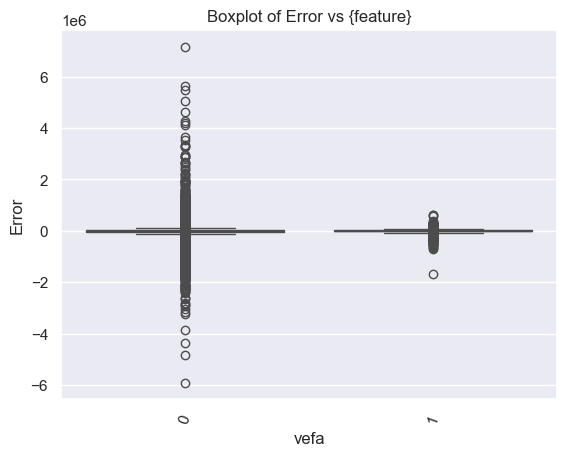

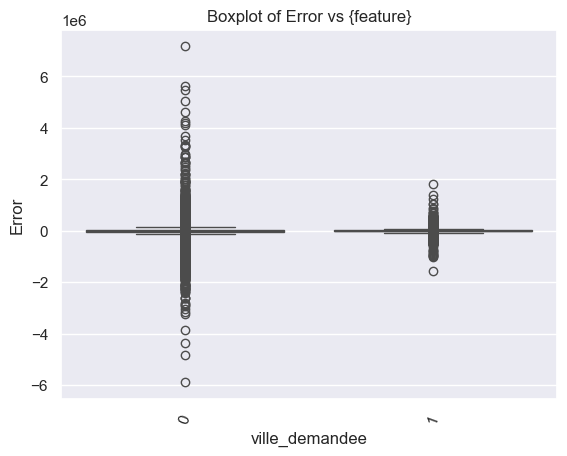

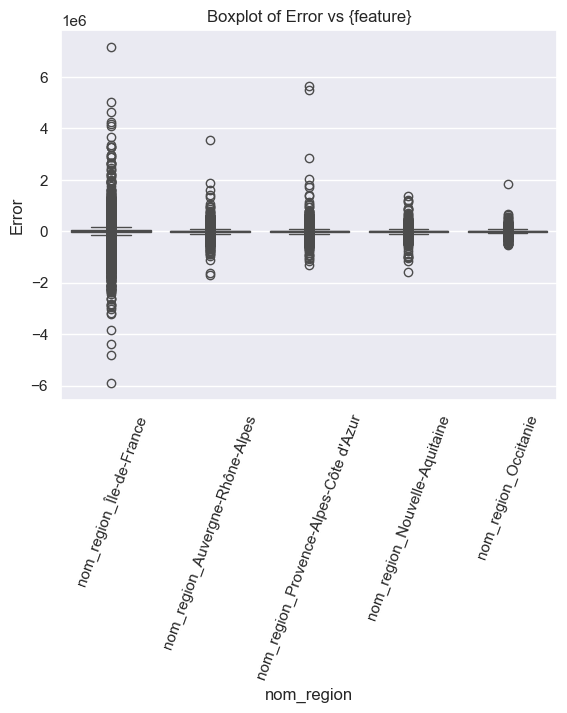

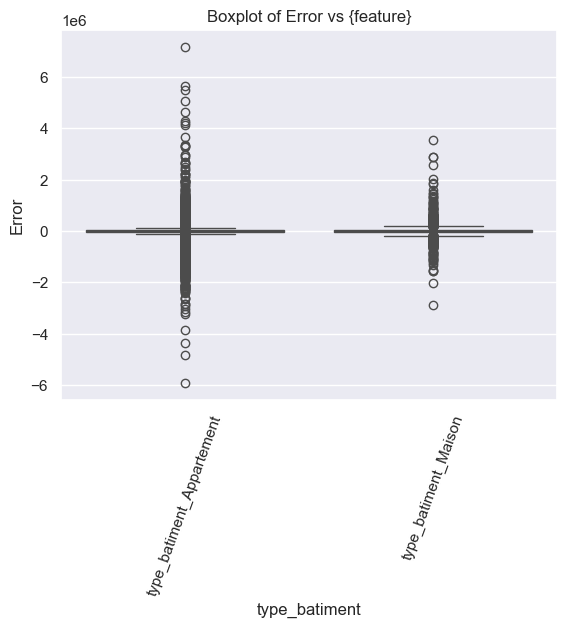

In [18]:
plot_error_violinplot(X_test_group, categorical_features_updated)